# NPE for Stochastic Lotka-Volterra: Visualization and Analysis

This notebook provides visualization and diagnostic tools for the Neural Posterior Estimation (NPE) implementation of the stochastic Lotka-Volterra model.

In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

from simulator import gillespie_lv, simulate_lv_batch
from utils import create_lv_prior, create_time_grid, flatten_trajectory, compute_summary_stats
from data_generation import LVDataGenerator
from inference import LVInference

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

/fred/oz022/tkimpson/conda_envs/NPE_LV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Simulator Visualization

Let's first visualize some example trajectories from the Gillespie simulator.

In [2]:
# Set up simulation parameters
prior = create_lv_prior()
t_grid = create_time_grid(t_max=15.0, dt=0.1)
x0 = (50, 100)

# Sample some parameter sets
n_examples = 6
theta_examples = prior.sample((n_examples,)).numpy()

print("Example parameter sets:")
param_names = ['α', 'β', 'δ', 'γ']
for i, theta in enumerate(theta_examples):
    param_str = ', '.join([f'{name}={val:.3f}' for name, val in zip(param_names, theta)])
    print(f"Set {i+1}: {param_str}")

Example parameter sets:
Set 1: α=0.558, β=0.074, δ=0.010, γ=0.722
Set 2: α=0.513, β=0.011, δ=0.066, γ=0.354
Set 3: α=0.192, β=0.024, δ=0.041, γ=0.306
Set 4: α=0.101, β=0.080, δ=0.073, γ=0.420
Set 5: α=0.080, β=0.004, δ=0.081, γ=0.205
Set 6: α=0.737, β=0.041, δ=0.084, γ=0.775


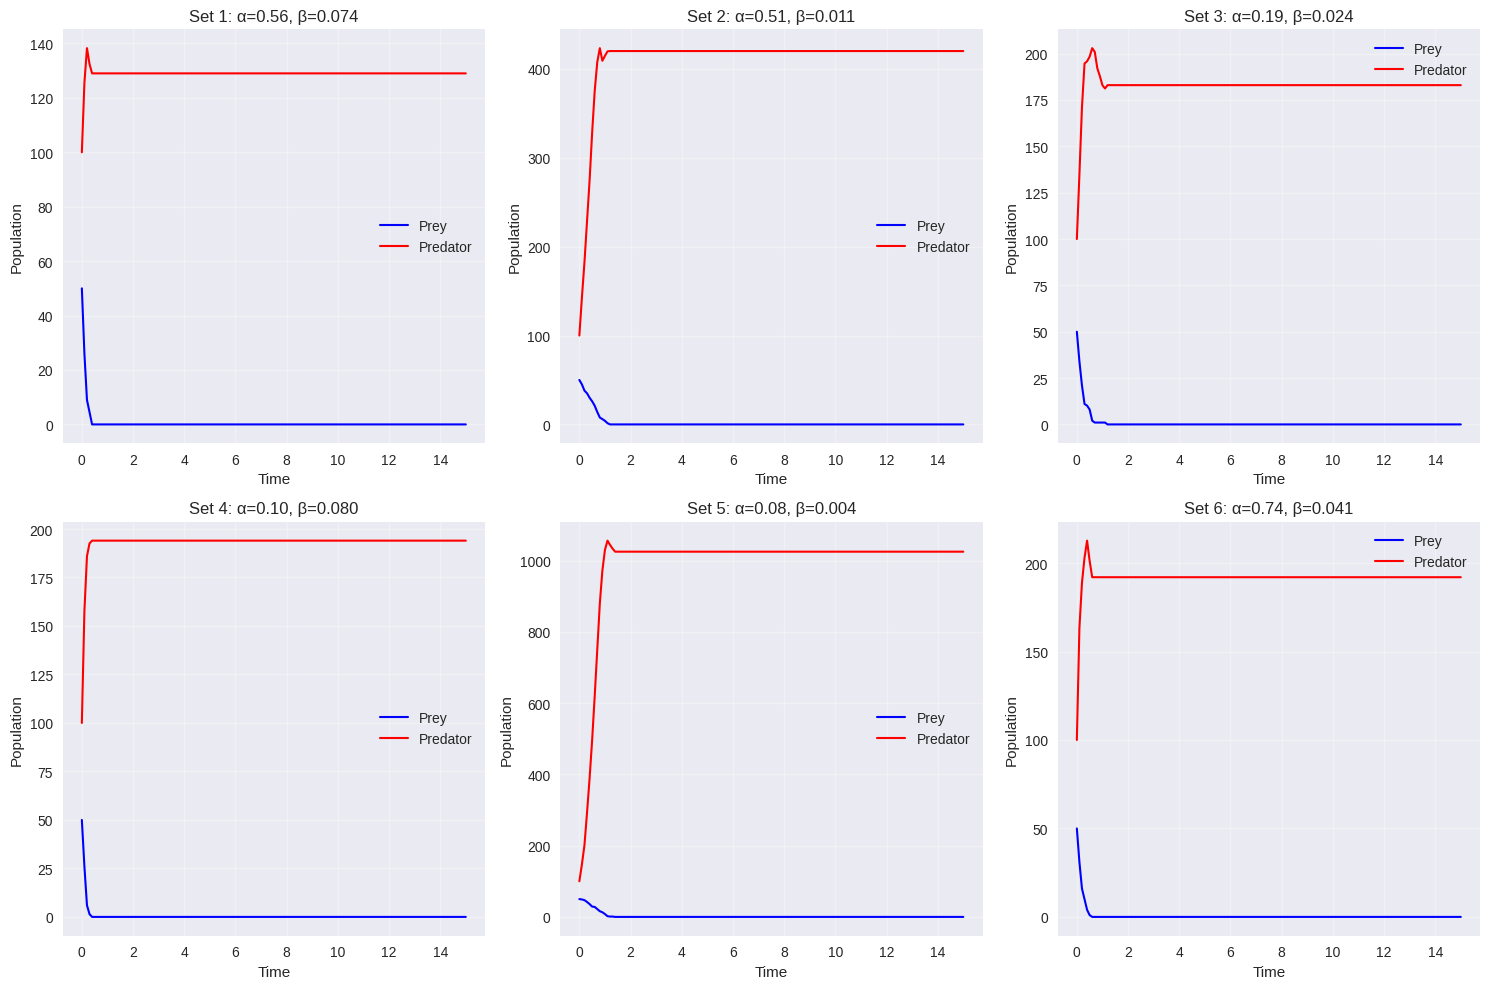

In [6]:
# Simulate trajectories
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (ax, theta) in enumerate(zip(axes, theta_examples)):
    try:
        # Simulate trajectory
        _, trajectory = gillespie_lv(theta, x0, t_max=15.0, t_grid=t_grid)
        
        # Plot
        ax.plot(t_grid, trajectory[:, 0], 'b-', label='Prey', linewidth=1.5)
        ax.plot(t_grid, trajectory[:, 1], 'r-', label='Predator', linewidth=1.5)
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.set_title(f'Set {i+1}: α={theta[0]:.2f}, β={theta[1]:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Simulation failed:\n{str(e)[:50]}...', 
               transform=ax.transAxes, ha='center', va='center')
        ax.set_title(f'Set {i+1}: Failed')

plt.tight_layout()
plt.show()

## 2. Prior Distribution Analysis

In [ ]:
# Sample from prior and visualize
prior_samples = prior.sample((5000,)).numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, param_names)):
    ax.hist(prior_samples[:, i], bins=50, alpha=0.7, color='skyblue', density=True)
    ax.set_xlabel(f'{name} value')
    ax.set_ylabel('Density')
    ax.set_title(f'Prior distribution: {name}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prior bounds:")
for i, name in enumerate(param_names):
    low = prior.support.low[i].item()
    high = prior.support.high[i].item()
    print(f"{name}: [{low:.3f}, {high:.3f}]")

## 3. Data Generation Analysis

Let's analyze the training data generation process.

In [ ]:
# Generate small batch of training data
generator = LVDataGenerator(
    x0=(50, 100),
    t_max=10.0,
    dt=0.1,
    use_summary_stats=False,
    seed=42
)

print("Generating sample training data...")
theta_sample, x_sample = generator.generate_batch(n_samples=100, batch_size=50)

print(f"Generated data shapes: theta={theta_sample.shape}, x={x_sample.shape}")
print(f"Success rate: {generator.get_stats()['success_rate']:.1%}")

In [ ]:
# Visualize some generated trajectories
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(x_sample):
        # Reshape flattened trajectory
        trajectory = x_sample[i].numpy().reshape(-1, 2)
        theta = theta_sample[i].numpy()
        
        ax.plot(t_grid, trajectory[:, 0], 'b-', label='Prey', linewidth=1.5)
        ax.plot(t_grid, trajectory[:, 1], 'r-', label='Predator', linewidth=1.5)
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.set_title(f'Sample {i+1}: α={theta[0]:.2f}, β={theta[1]:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Summary Statistics Comparison

In [ ]:
# Compare full trajectory vs summary statistics
generator_summary = LVDataGenerator(
    x0=(50, 100),
    t_max=10.0,
    dt=0.1,
    use_summary_stats=True,
    seed=42
)

theta_test, x_summary = generator_summary.generate_batch(n_samples=50, batch_size=25)

print(f"Full trajectory dimension: {x_sample.shape[1]}")
print(f"Summary statistics dimension: {x_summary.shape[1]}")
print(f"Compression ratio: {x_sample.shape[1] / x_summary.shape[1]:.1f}x")

# Show example summary statistics
print("\nExample summary statistics:")
print("(mean_prey, std_prey, min_prey, max_prey, peak_time_prey, autocorr_prey,")
print(" mean_pred, std_pred, min_pred, max_pred, peak_time_pred, autocorr_pred)")
for i in range(min(3, len(x_summary))):
    print(f"Sample {i+1}: {x_summary[i].numpy()}")

## 5. Model Training Visualization

Functions to visualize training progress (use after training a model).

In [ ]:
def plot_training_curves(training_info):
    """Plot training and validation loss curves."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = range(1, len(training_info['train_log_probs']) + 1)
    
    ax.plot(epochs, -np.array(training_info['train_log_probs']), 
           'b-', label='Training Loss', linewidth=2)
    ax.plot(epochs, -np.array(training_info['validation_log_probs']), 
           'r-', label='Validation Loss', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Negative Log Probability')
    ax.set_title('NPE Training Progress')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final training loss: {-training_info['train_log_probs'][-1]:.4f}")
    print(f"Final validation loss: {-training_info['validation_log_probs'][-1]:.4f}")
    print(f"Training epochs: {len(training_info['train_log_probs'])}")

# Example usage (uncomment when you have trained a model):
# training_info = {...}  # from training script
# plot_training_curves(training_info)

## 6. Posterior Predictive Checks

Functions for validating trained models.

In [ ]:
def posterior_predictive_check(inference_model, theta_true, x_obs, n_samples=100):
    """Perform posterior predictive check."""
    
    # Sample from posterior
    posterior_samples = inference_model.sample_posterior(x_obs, num_samples=n_samples)
    
    # Simulate data from posterior samples
    t_grid = create_time_grid(10.0, 0.1)
    x0 = (50, 100)
    
    predicted_trajectories = []
    
    for i in range(min(20, len(posterior_samples))):
        theta_sample = posterior_samples[i].numpy()
        try:
            _, traj = gillespie_lv(theta_sample, x0, 10.0, t_grid)
            predicted_trajectories.append(traj)
        except:
            continue
    
    if len(predicted_trajectories) == 0:
        print("No successful predictions generated")
        return
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Reconstruct true trajectory if using full data
    if not inference_model.use_summary_stats:
        true_trajectory = x_obs.numpy().reshape(-1, 2)
        ax1.plot(t_grid, true_trajectory[:, 0], 'b-', linewidth=3, label='True (Prey)', alpha=0.8)
        ax2.plot(t_grid, true_trajectory[:, 1], 'r-', linewidth=3, label='True (Predator)', alpha=0.8)
    
    # Plot predicted trajectories
    for i, traj in enumerate(predicted_trajectories):
        alpha = 0.1 if i > 0 else 0.3
        label_prey = 'Predicted (Prey)' if i == 0 else None
        label_pred = 'Predicted (Predator)' if i == 0 else None
        
        ax1.plot(t_grid, traj[:, 0], 'b-', alpha=alpha, label=label_prey)
        ax2.plot(t_grid, traj[:, 1], 'r-', alpha=alpha, label=label_pred)
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Prey Population')
    ax1.set_title('Posterior Predictive Check: Prey')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Predator Population')
    ax2.set_title('Posterior Predictive Check: Predator')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return posterior_samples

## 7. Coverage Analysis

In [ ]:
def analyze_coverage(inference_model, n_tests=50, confidence_level=0.95):
    """Analyze posterior coverage using simulation-based calibration."""
    
    prior = create_lv_prior()
    t_grid = create_time_grid(10.0, 0.1)
    x0 = (50, 100)
    
    coverage_results = []
    
    for i in tqdm(range(n_tests), desc="Coverage analysis"):
        # Sample true parameters
        theta_true = prior.sample((1,)).numpy()[0]
        
        try:
            # Generate synthetic observation
            _, trajectory = gillespie_lv(theta_true, x0, 10.0, t_grid)
            
            if inference_model.use_summary_stats:
                x_obs = torch.tensor(compute_summary_stats(trajectory, t_grid), dtype=torch.float32)
            else:
                x_obs = torch.tensor(flatten_trajectory(trajectory), dtype=torch.float32)
            
            # Sample from posterior
            posterior_samples = inference_model.sample_posterior(x_obs, num_samples=1000)
            
            # Check coverage for each parameter
            test_result = []
            for j in range(4):
                samples_j = posterior_samples[:, j].numpy()
                alpha = 1 - confidence_level
                lower = np.percentile(samples_j, 100 * alpha / 2)
                upper = np.percentile(samples_j, 100 * (1 - alpha / 2))
                
                covered = lower <= theta_true[j] <= upper
                test_result.append(covered)
            
            coverage_results.append(test_result)
            
        except Exception as e:
            print(f"Test {i} failed: {e}")
            continue
    
    # Analyze results
    coverage_results = np.array(coverage_results)
    coverage_rates = np.mean(coverage_results, axis=0)
    
    print(f"\nCoverage Analysis ({confidence_level:.0%} credible intervals):")
    print("-" * 50)
    for i, name in enumerate(param_names):
        rate = coverage_rates[i]
        print(f"{name}: {rate:.2%} (expected: {confidence_level:.0%})")
    
    overall_coverage = np.mean(coverage_rates)
    print(f"\nOverall coverage: {overall_coverage:.2%}")
    
    return coverage_rates, coverage_results

## 8. Usage Examples

Here are examples of how to use the functions above after training a model:

In [ ]:
# Example workflow (uncomment and modify paths as needed):

# 1. Load trained model
# inference = LVInference.load_model('../models/npe_model.pkl')

# 2. Generate test observation
# theta_true = np.array([0.5, 0.025, 0.025, 0.5])
# t_grid = create_time_grid(10.0, 0.1)
# _, trajectory = gillespie_lv(theta_true, (50, 100), 10.0, t_grid)
# x_obs = torch.tensor(flatten_trajectory(trajectory), dtype=torch.float32)

# 3. Run posterior predictive check
# posterior_samples = posterior_predictive_check(inference, theta_true, x_obs)

# 4. Analyze coverage
# coverage_rates, _ = analyze_coverage(inference, n_tests=20)

print("Visualization notebook ready!")
print("Uncomment and run the examples above after training a model.")